In [1]:
# LIBRARY:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
#import researchpy as rp
import seaborn as sns
import numpy as np

import statsmodels as sa

%matplotlib inline
%matplotlib nbagg

%cd /Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES/

/Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES


In [3]:
# Import dataset:

df = pd.read_csv('GTEX-ALL_SAMPLES.v8.phASER.gw_phased.results.fdr_ALL.gene_info.zscores.txt.gz', sep='\t', compression='gzip')

# add column for GENE_IDs without version #:
df[['GENE_ID.v2','ens_version']] = df['GENE_ID'].str.split('.',expand=True)

df.head()

/Users/snkravitz/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,mean_read_counts,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,GENE_ID.v2,ens_version
0,1,ENSG00000228794.8,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,58.0,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,ENSG00000228794,8
1,1,ENSG00000223764.2,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,38.0,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,ENSG00000223764,2
2,1,ENSG00000188976.10,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,178.0,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,ENSG00000188976,10
3,1,ENSG00000187961.13,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,24.0,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,ENSG00000187961,13
4,1,ENSG00000187583.10,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,96.0,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,ENSG00000187583,10


In [4]:
## Filter out X-Chr genes, Imprinted genes, and HLA genes:

# Remove X-Chr:
df = df[df['CHR'] != 'X']

# Remove HLA genes:
df = df[~df['GENE_NAME'].str.contains("HLA")]

# Remove Imprinted Genes:
imprinted_df = pd.read_csv("~/Documents/Gene_Lists/GTEx_Imprinting/GTEx_Imprinted_Table_S3andS4.uniq.txt", sep=' ', names=['GENE_ID', 'chrom', 'start'])
imprinted_genes = list(imprinted_df['GENE_ID'])
#imprinted_genes
df = df[~df['GENE_ID.v2'].isin(imprinted_genes)]

In [5]:
df.head()

,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,mean_read_counts,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,GENE_ID.v2,ens_version
0,1,ENSG00000228794.8,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,58.0,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,ENSG00000228794,8
1,1,ENSG00000223764.2,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,38.0,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,ENSG00000223764,2
2,1,ENSG00000188976.10,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,178.0,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,ENSG00000188976,10
3,1,ENSG00000187961.13,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,24.0,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,ENSG00000187961,13
4,1,ENSG00000187583.10,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,96.0,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,ENSG00000187583,10


In [6]:
## Get gene length info from GTF file:

gene_length = pd.read_csv("../QC_SupplementalFigures/gencode.v26.GRCh38.genes.gtf.genelength", sep='\t', names=['GENE_ID', 'mean', 'median', 'longest_isoform', 'merged'])

# add column for GENE_IDs without version #:
#gene_length[['GENE_ID','ens_version']] = gene_length['gene'].str.split('.',expand=True)

gene_length.head()

,GENE_ID,mean,median,longest_isoform,merged
0,gene,mean,median,longest_isoform,merged
1,ENSG00000242268.2,710,710,710,710
2,ENSG00000188026.12,3756,3756,3756,3756
3,ENSG00000270112.3,4685,4685,4685,4685
4,ENSG00000280143.1,3308,3308,3308,3308


In [7]:
## Merge gene length to original dataframe:

df = df.merge(gene_length[['GENE_ID', 'longest_isoform']], how='left', on='GENE_ID')

df.head()

,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,...,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,GENE_ID.v2,ens_version,longest_isoform
0,1,ENSG00000228794.8,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,...,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,ENSG00000228794,8,8694
1,1,ENSG00000223764.2,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,...,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,ENSG00000223764,2,1389
2,1,ENSG00000188976.10,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,...,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,ENSG00000188976,10,2633
3,1,ENSG00000187961.13,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,...,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,ENSG00000187961,13,2910
4,1,ENSG00000187583.10,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,...,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,ENSG00000187583,10,2560


In [7]:
## Plotting z-score vs. gene length:

# Get deciles of gene length:
## Where the deciles are based on the RANGE of med_tpms (therefore the bins will not have equal # of genes)

uniq_counts = df['longest_isoform'].unique()

pctiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

pctile_counts = []
for p in pctiles:
    pctile_counts.append(np.percentile(uniq_counts, p, interpolation='nearest'))
    
print(pctile_counts)

# Subset df by mean read counts (deciles):
expression_dfs = []
for index, p in enumerate(pctile_counts[0:len(pctile_counts)-1]):
    lower = p
    upper = pctile_counts[index + 1]
    df_subset = df['data_qvalues'][df['longest_isoform'].between(lower, upper)].to_frame()
    df_subset['percentile'] = (index + 1) * 10
    expression_dfs.append(df_subset)

df_pctile_vals = pd.concat(expression_dfs, ignore_index=True)

# merge percentiles with original df:
df_length = df.merge(df_pctile_vals['percentile'], left_index=True, right_index=True)
df_length.head()

['100', '1286', '1786', '2515', '3315', '4147', '5001', '5934', '6961', '8272', '9998']


,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,...,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,GENE_ID.v2,ens_version,longest_isoform,percentile
0,1,ENSG00000228794.8,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,...,NaN,414,74.0,0.178744,0.315991,private_RME,ENSG00000228794,8,8694,10
1,1,ENSG00000223764.2,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,...,NaN,492,132.0,0.268293,0.915775,private_RME,ENSG00000223764,2,1389,10
2,1,ENSG00000188976.10,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,...,NaN,532,48.0,0.090226,-0.276891,private_RME,ENSG00000188976,10,2633,10
3,1,ENSG00000187961.13,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,...,NaN,473,34.0,0.071882,-0.399756,private_RME,ENSG00000187961,13,2910,10
4,1,ENSG00000187583.10,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,...,NaN,566,47.0,0.083039,-0.325026,private_RME,ENSG00000187583,10,2560,10


<IPython.core.display.Javascript object>


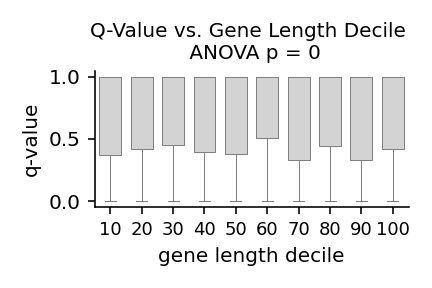

In [8]:
# Plot Q-Value vs. Gene Length (decile)
f, ax = plt.subplots(figsize=(3,2), tight_layout=True)
sns.despine()
#sns.set_palette("husl")

anova_p = stats.f_oneway(*(df_length[df_length['percentile'] == p]['data_qvalues'].dropna() for p in np.linspace(10, 100, 10)))

ax = sns.boxplot(data=df_length, x = 'percentile', y = 'data_qvalues', linewidth=0.5, fliersize=0.1, width=0.7, color="lightgray")
ax.set_xlabel('gene length decile', fontsize=10)
ax.set_ylabel('q-value', fontsize=10)
ax.set_xticklabels(np.linspace(10,100, 10).astype(int), size=9)
ax.set_title('Q-Value vs. Gene Length Decile \n ANOVA p = %.2g' % anova_p.pvalue, fontsize=10)

f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.gene_length_decile.vs.q-val.pdf', transparent=True)

In [9]:
## Plotting Q-Values vs. Gene Length:

# Get deciles of Gene Lengths:
## Where the deciles are EVENLY binned, i.e. sort the data by gene length, and slice evenly
df_length = df_length.sort_values(by='longest_isoform').reset_index()

length_bins = np.linspace(0,df_length.shape[0], 20).astype(int)
print(length_bins)

# Subset df by mean read counts (deciles):
length_deciles = []
for index, p in enumerate(length_bins[0:len(length_bins)-1]):
    lower = p
    upper = length_bins[index + 1]
    df_subset = df_length.iloc[lower:upper]
    #df_subset = df['data_qvalues'][df['mean_read_counts'].between(lower, upper)].to_frame()
    df_subset['percentile'] = (index + 1) * 5
    length_deciles.append(df_subset)
    
df_pctile_vals = pd.concat(length_deciles, ignore_index=True)

[      0  474179  948358 1422538 1896717 2370897 2845076 3319256 3793435
 4267615 4741794 5215974 5690153 6164333 6638512 7112692 7586871 8061051
 8535230 9009410]


<ipython-input-9-c5c4c12686e0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['percentile'] = (index + 1) * 5


<IPython.core.display.Javascript object>


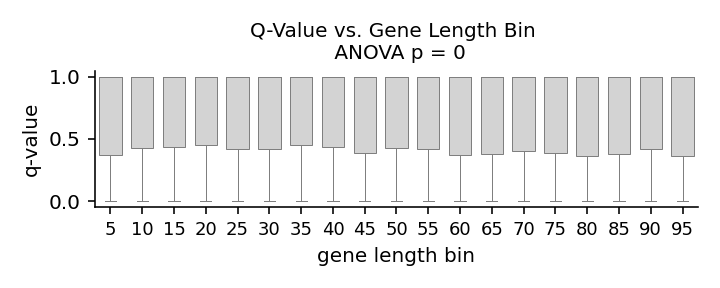

In [11]:
# Plot Q-Value vs. Gene Length (bins)
f, ax = plt.subplots(figsize=(5,2), tight_layout=True)
sns.despine()

anova_p = stats.f_oneway(*(df_pctile_vals[df_pctile_vals['percentile'] == p]['data_qvalues'].dropna() for p in np.linspace(5, 95, 19)))

ax = sns.boxplot(data=df_pctile_vals, x = 'percentile', y = 'data_qvalues', linewidth=0.5, fliersize=0.1, width=0.7, color="lightgray")
ax.set_xlabel('gene length bin', fontsize=10)
ax.set_ylabel('q-value', fontsize=10)
ax.set_xticklabels(np.linspace(5, 95, 19).astype(int), size=9)
ax.set_title('Q-Value vs. Gene Length Bin \n ANOVA p = %.2g' % anova_p.pvalue, fontsize=10)
             
#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.gene_length_bins.vs.q-val.png', dpi=400) #transparent=True)

<IPython.core.display.Javascript object>


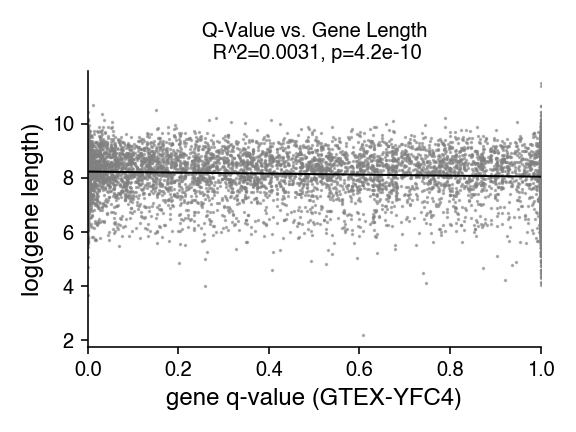

In [15]:
## Regplot of q-val vs. gene length for GTEX-YFC4

f, ax = plt.subplots(figsize=(4,3), tight_layout=True)
sns.despine()

df_plot = df[df['SUBJECT_ID'] == 'GTEX-YFC4']

slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['data_qvalues'],df_plot['longest_isoform'].astype(int))
r_squared = r_value ** 2

ax = sns.regplot(data=df_plot, x=df_plot['data_qvalues'], y=np.log1p(df_plot['longest_isoform'].astype(int)), fit_reg=True, truncate=True, ci=95, scatter_kws={"color":"grey", "s": 0.5, "alpha": 0.6, 'rasterized': True}, line_kws={"color":"black", "lw":1})
ax.set_xlabel('gene q-value (GTEX-YFC4)', fontsize=12, fontweight='light')
ax.set_ylabel('log(gene length)', fontsize=12, fontweight='light')
#ax.set_ylim(0, 8)
#ax.set_xlim(0, 20)
ax.set_title('Q-Value vs. Gene Length\n R^2={0:.2g}, p={1:.2g}'.format(r_squared,p_value), fontsize=10)

#plt.show()


#f.savefig('/Users/snkravitz/Desktop/q-val_figs/GTEX-YFC4.all-tissues.gene_length.vs.q-val.regplot.pdf', dpi=400, transparent=True)
